## My Kaggle Mini Project

### Step 1 Problem description


The challenge problem is to identify cancer in the input images. It is a binary classification where 1st class(label - 0) are images of healthy cells and the 2nd class images are images of cells that have metastatic cancer.

The input data is 96x96 pixels. However, labels indicate that cancer exists in middle 32x32 image square. Also we have 3 RGB channels, so the input is actually 96x96x3.

### Step 2 Exploratory data analysis
Let's see how many samples we have:

In [23]:
import numpy as np
import pandas as pd
import os

train_path = '../input/histopathologic-cancer-detection/train'
test_path = '../input/histopathologic-cancer-detection/test'

for name, path in ('train', train_path), ('test', test_path):
    print(name.capitalize() + ' - ', end='')
    numSamples = len(os.listdir(path))
    print(f'Sample count: {numSamples}')

Train - Sample count: 220025
Test - Sample count: 57458


We have 220025 train images and 57458 test images.
But to train a NN for the binary classification, we should make sure that our data is balanced(no disbalance between each class samples count).

0    130908
1     89117
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

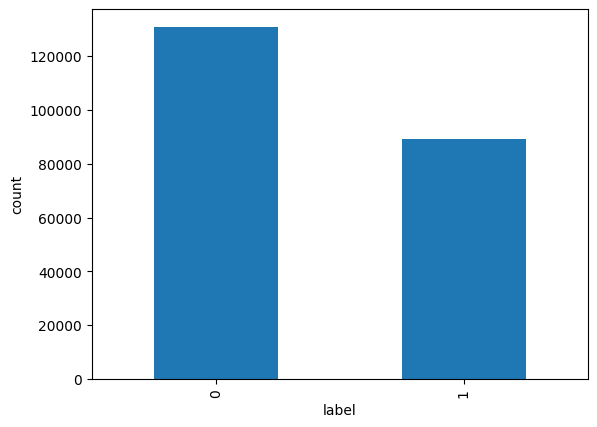

In [24]:
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
label10counts = train_labels['label'].value_counts()
print(label10counts)
label10counts.plot(kind='bar', xlabel='label', ylabel='count')

As we can see on the previous graph, we have more healthy cells images than unlealthy.
So let's make the sample count equal for each label.

0    89117
1    89117
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

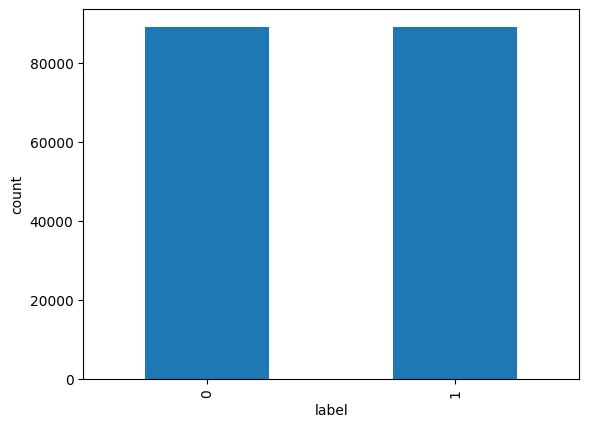

In [25]:
train_labels_1 = train_labels[train_labels['label'] == 1]
train_labels_0 = train_labels[train_labels['label'] == 0]
train_labels = pd.concat(
    [train_labels_1, train_labels_0.sample(n=train_labels_1.shape[0], random_state=42)]
).sample(
    frac=1, random_state=42
).reset_index(
    drop=True
)
label10counts = train_labels['label'].value_counts()
print(label10counts)
label10counts.plot(kind='bar', xlabel='label', ylabel='count')

Now the sample dataframe is balanced.
Next, let's look at the images to visually see the problem.

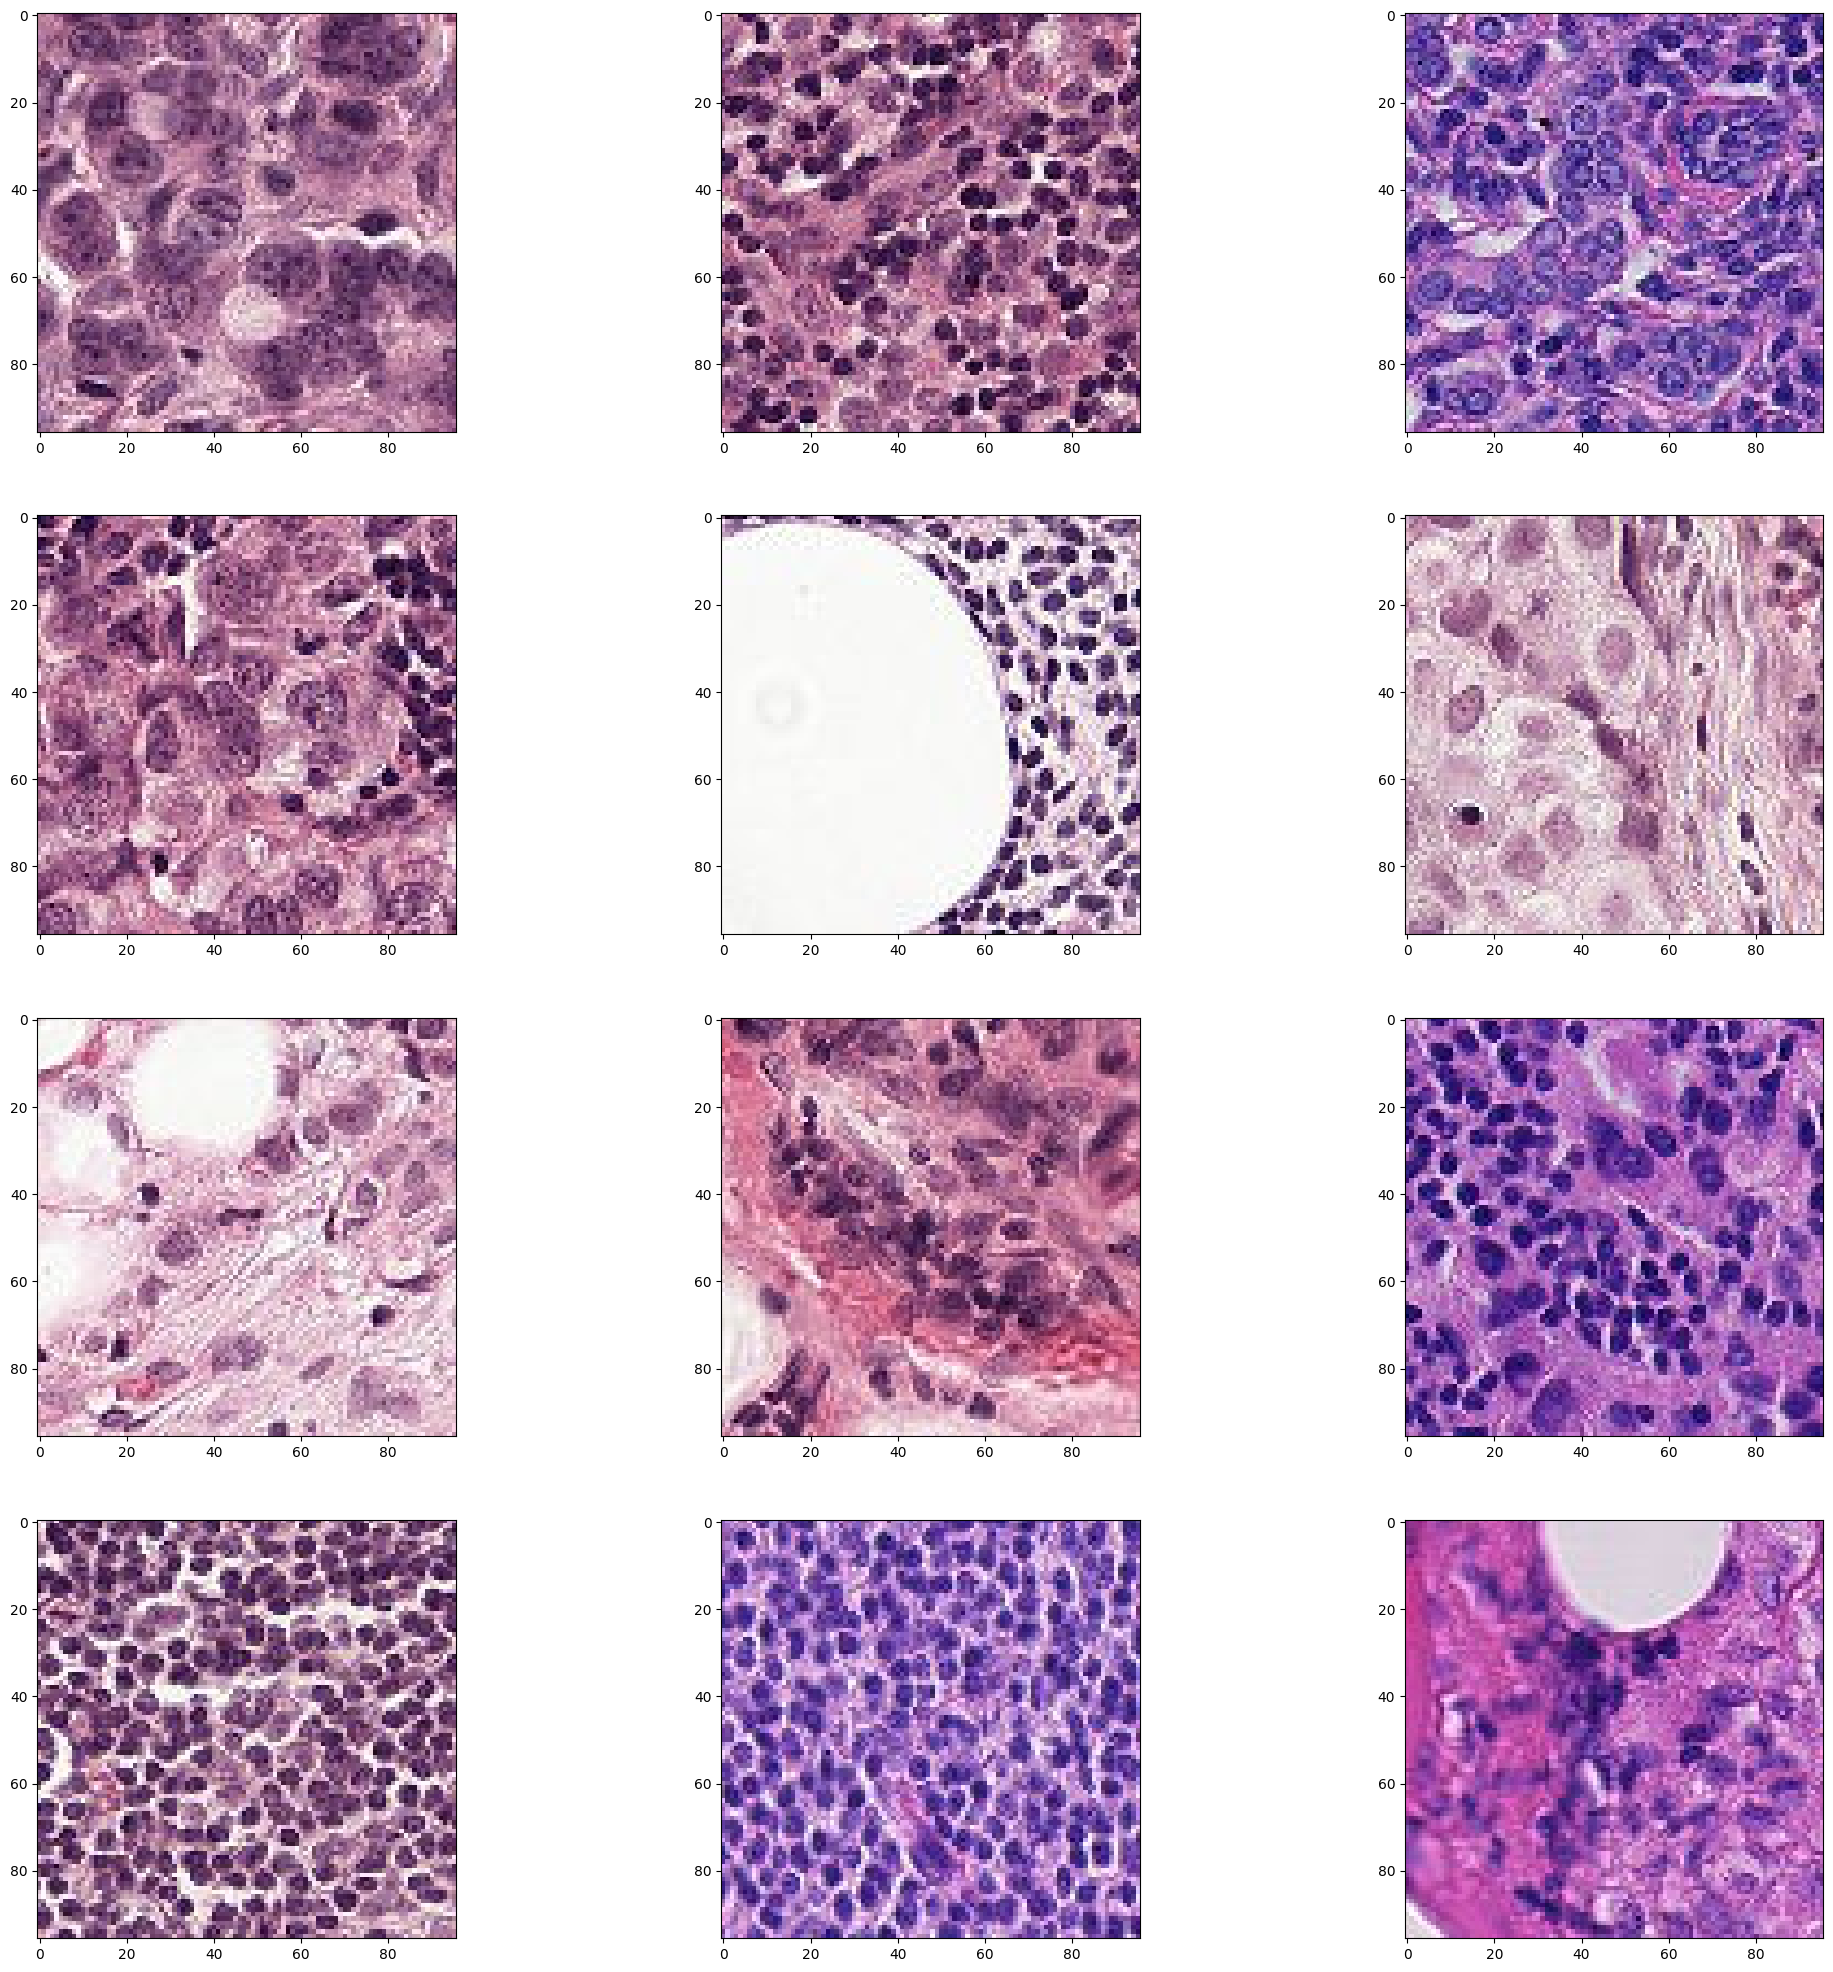

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def imgPathFromLabel(path, label):
    return os.path.join(path, f'{label}.tif')

def getImgFromLabel(label, test=False):
    path = test and test_path or train_path
    return mpimg.imread(imgPathFromLabel(path, label))

fig, ax = plt.subplots(4, 3, figsize=(25, 25))

sample_ids = np.random.choice(train_labels['id'], 12)

for i in range(sample_ids.shape[0]):
    ax = plt.subplot(4, 3, i+1)
    ax.imshow(getImgFromLabel(sample_ids[i]))

Next, let's make data generators to prepare the data for NN training.<br>
Let's split the train data to train and test dataframes(we don't use input test folder because we don't know labels for it. So we create train and test dataframes only from known data).<br>
We should also rescale the data pixel brightness(for each channel) to float value by dividing it by maximum intensivity (255).<br>
For 'id' column, we chould add the .tif file extension to get the input file names ready to be used by the generators.<br>
Also the labels should be converted to string values.<br>

In [50]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Dense, 
    Activation, 
    Dropout, 
    Flatten, 
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    PReLU
)
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

train, valid = train_test_split(
    train_labels, 
    random_state=42, 
    test_size=0.25, 
    stratify=train_labels['label']
)
train['id'] += '.tif'
valid['id'] += '.tif'
train['label'] = train['label'].astype(str)
valid['label'] = valid['label'].astype(str)

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train, 
    directory=train_path, 
    x_col='id', 
    y_col='label',
    class_mode='binary',
    target_size=(96, 96)
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe = valid, 
    directory=train_path, 
    x_col='id', 
    y_col='label',
    class_mode='binary',
    target_size=(96, 96)
)

Found 133675 validated image filenames belonging to 2 classes.
Found 44559 validated image filenames belonging to 2 classes.


The data is prepared to use by the neural network now!<br>
## Step 3 Model architecture
Finally, let's design the model architecture!<br>

At first, let's use a standard deep CNN - VGGNet model architecture. I choose this model because it is a simple, popular and trustworthy model and it is definitelly good enough for binary classification.<br>
Of course, we should try something more complex to reach higher places on the leaderbord but I am only beginning to learn neural networks so my goal is just to make a simple and understandable architecture that will be trained in reasonable period of time.<br>

But let's use a bit simplified version of VGGNet so it will be trained faster.

After creating the model, let's see the architecture info by using `model.summary()` command.<br>

In [28]:
model1 = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    Activation('relu'),
    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(),
    
    Conv2D(128, (3, 3)),
    Activation('relu'),
    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(),
    
    Flatten(),

    Dense(128),
    Activation('relu'),

    Dense(64),
    Activation('relu'),

    Dense(1),
    Activation('sigmoid'),
])

model1.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
activation_36 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
activation_37 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 44, 44, 64)       

Epoch 1/5
4177/4177 [==============================] - 262s 63ms/step - loss: 0.4693 - accuracy: 0.7906 - val_loss: 0.3853 - val_accuracy: 0.8209
Epoch 2/5
4177/4177 [==============================] - 276s 66ms/step - loss: 0.3288 - accuracy: 0.8670 - val_loss: 0.3769 - val_accuracy: 0.8459
Epoch 3/5
4177/4177 [==============================] - 271s 65ms/step - loss: 0.2780 - accuracy: 0.8903 - val_loss: 0.9744 - val_accuracy: 0.8146
Epoch 4/5
4177/4177 [==============================] - 264s 63ms/step - loss: 0.2411 - accuracy: 0.9082 - val_loss: 0.3245 - val_accuracy: 0.8547
Epoch 5/5
4177/4177 [==============================] - 253s 61ms/step - loss: 0.2285 - accuracy: 0.9133 - val_loss: 0.3397 - val_accuracy: 0.8575


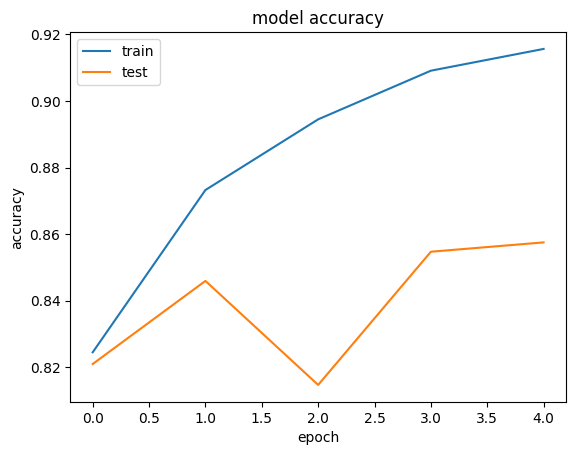

In [29]:
epochs = 8

history = model1.fit(
    x=train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    epochs=epochs
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can see that the model works and results aren't bad(for my goals).<br>
But let's try to improve the results by adding parametrized ReLU (PReLU) activation functions that can improve the training process.<br>
Also let's try to add batch normalization and some dropouts.

In [30]:
model2 = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    PReLU(Constant(0.25)),
    Conv2D(32, (3, 3)),
    PReLU(Constant(0.25)),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), input_shape=(96, 96, 3)),
    PReLU(Constant(0.25)),
    Conv2D(64, (3, 3)),
    PReLU(Constant(0.25)),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), input_shape=(96, 96, 3)),
    PReLU(Constant(0.25)),
    Conv2D(128, (3, 3)),
    PReLU(Constant(0.25)),
    MaxPooling2D(),
    BatchNormalization(),
    
    Flatten(),
    Dropout(0.25),
    Dense(128),
    PReLU(Constant(0.25)),

    Dropout(0.25),
    Dense(64),
    PReLU(Constant(0.25)),

    Dropout(0.25),
    Dense(1),
    Activation('sigmoid'),
])

model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 94, 94, 32)        282752    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 92, 92, 32)        270848    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 44, 44, 64)       

Epoch 1/5
4177/4177 [==============================] - 188s 45ms/step - loss: 0.3481 - accuracy: 0.8521 - val_loss: 0.4911 - val_accuracy: 0.8003
Epoch 2/5
4177/4177 [==============================] - 188s 45ms/step - loss: 0.3324 - accuracy: 0.8607 - val_loss: 0.7300 - val_accuracy: 0.7540
Epoch 3/5
4177/4177 [==============================] - 193s 46ms/step - loss: 0.3146 - accuracy: 0.8690 - val_loss: 0.9636 - val_accuracy: 0.6916
Epoch 4/5
4177/4177 [==============================] - 198s 47ms/step - loss: 0.2921 - accuracy: 0.8798 - val_loss: 0.5597 - val_accuracy: 0.7933
Epoch 5/5
4177/4177 [==============================] - 173s 41ms/step - loss: 0.2717 - accuracy: 0.8878 - val_loss: 0.4286 - val_accuracy: 0.8295


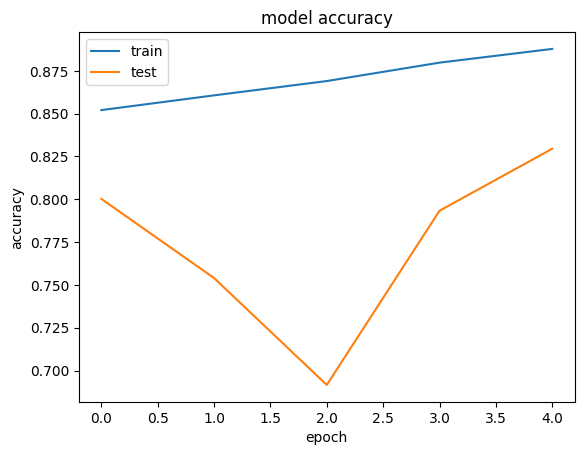

In [36]:
epochs = 8

history = model2.fit(
    x=train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    epochs=epochs
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We did not have positive effect by adding PReLU.<br>
Let's try to add Leaky ReLU and increased dropouts.

In [58]:
from keras.layers.advanced_activations import LeakyReLU

model3 = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    LeakyReLU(),
    Conv2D(32, (3, 3)),
    LeakyReLU(),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(64, (3, 3)),
    LeakyReLU(),
    Conv2D(64, (3, 3)),
    LeakyReLU(),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(128, (3, 3)),
    LeakyReLU(),
    Conv2D(128, (3, 3)),
    LeakyReLU(),
    MaxPooling2D(),
    BatchNormalization(),
        
    Flatten(),
    Dropout(0.5),
    Dense(128),
    LeakyReLU(),
    
    Dropout(0.5),
    Dense(64),
    LeakyReLU(),

    Dropout(0.5),
    Dense(1),
    Activation('sigmoid'),
])

model3.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/5
4177/4177 [==============================] - 275s 66ms/step - loss: 0.8280 - accuracy: 0.7548 - val_loss: 0.6992 - val_accuracy: 0.6444
Epoch 2/5
4177/4177 [==============================] - 274s 66ms/step - loss: 0.3834 - accuracy: 0.8391 - val_loss: 0.4066 - val_accuracy: 0.8297
Epoch 3/5
4177/4177 [==============================] - 270s 65ms/step - loss: 0.3200 - accuracy: 0.8694 - val_loss: 0.4810 - val_accuracy: 0.7720
Epoch 4/5
4177/4177 [==============================] - 274s 66ms/step - loss: 0.2927 - accuracy: 0.8841 - val_loss: 0.3357 - val_accuracy: 0.8844
Epoch 5/5
4177/4177 [==============================] - 275s 66ms/step - loss: 0.2707 - accuracy: 0.8925 - val_loss: 0.2644 - val_accuracy: 0.8872


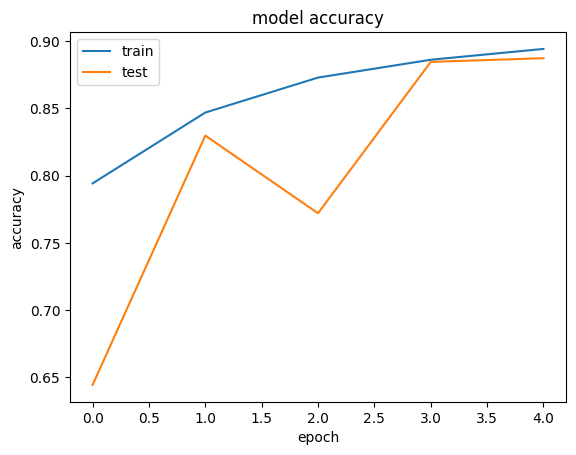

In [59]:
epochs = 5

history = model3.fit(
    x=train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It seems that it helped to add Leaky ReLU layer.

### Step 4 Results and analysis
We have good enough resuts now. Validation accuracy is ~0.89.<br>
We can say, that according to our tests, it helped to add a Leaky ReLU layer.<br>
Also I tried lowering optimizer learning rate and increasing epochs, I had nearly same results while spent more time, therefore, there is no sense to do it.<br>

### Step 4 Conclusion
Suming up, we tried different architectures of convolutional neural networks for this task.<br>
It helped to add Leaky ReLU layers to the network, and it did not help to add normalization in our case.<br>
But I would try such things as pretrained network's weights to better understand the features of the image classes.<br>

Let's submit the results.

In [ ]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_df = submission.copy()
test_df.head()

In [ ]:
test_df['file'] = test_df['id'] + '.tif'
test_df.head()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=test_path, x_col='file', batch_size=64, seed=42, shuffle=False, class_mode=None, target_size=(96, 96))

In [ ]:

preds = model3.predict(test_generator, steps=test_generator.n/64, verbose=True)
preds = [i >= 0.5 and 1 or 0 for i in preds]


In [ ]:
submission['label'] = preds
submission.head()

In [ ]:
submission.to_csv('submission.csv', header=True, index=False)